In [1]:
import cmocean.cm as cm
import copy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from sklearn.decomposition import PCA
from salishsea_tools import viz_tools
from scipy import signal

#### 1. Load in the data and plot 6 days from throughout the dataset

In [2]:
# open dataset - should be day-averaged
physics_201905 = xr.open_dataset('/ocean/cdonaldson/compare_daily_river/SalishSeaCast_1d_salinity_20190101_20191231.nc')
physics_202111 = xr.open_dataset('/ocean/cdonaldson/compare_daily_river/SalishSeaCast_day_avg_physics_20190101_20191231.nc')

In [7]:
def process_and_pca(physics):  # TODO change savefig options to fn iput?

    ## PRE-PROCESSING PART
    phys_arr = physics.vosaline.to_numpy()

    # define dimensions for later reshaping
    num_days = phys_arr.shape[0]

    Nx = phys_arr.shape[2]
    Ny = phys_arr.shape[3]

    # make a mask of land where land is true and water in NaN
    bathymetry = xr.open_dataset('../../../../MEOPAR/grid/bathymetry_201702.nc')
    land = np.array(np.isnan(bathymetry.Bathymetry).to_numpy(), dtype='float')
    land[land == 0] = np.nan

    # make the indicies for plotting six sample salinity fields
    plot_ind = np.array([[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]])
    plot_day = np.array([0, 50, 100, 150, 200, 250])  # this selects what days of each year to plot, change for > 1 year

    # open the mesh mask and use it to mask the land
    mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask201702.nc')
    # the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
    tmask = 1 - mesh.tmask[0]

    kd = 0 ## this will stay for surface
    imin = 0
    imax = 898
    jmin = 0
    jmax = 398
    dm = physics

    fig1, ax1 = plt.subplots(2, 3, figsize=(12, 7))


    ## SHOWS SALINITY PLOTS
    for i in np.arange(0,6):
        
        cmap = cm.haline
        cmap.set_bad('gray')

        
        day = plot_day[i]
        day_str = np.datetime_as_string(physics.time[day].values, unit='D')
        # salinity plot
        myarray = np.ma.array(dm.vosaline[day, kd, imin:imax, jmin:jmax])
        salinity = np.ma.masked_array(myarray, mask=tmask[0])
        colours = ax1[plot_ind[i][0], plot_ind[i][1]].pcolormesh(np.arange(jmin, jmax), np.arange(imin, imax), salinity, cmap=cm.haline, shading='auto')
        ax1[plot_ind[i][0], plot_ind[i][1]].set_title(day_str)
        cb = fig1.colorbar(colours, ax=ax1[plot_ind[i][0], plot_ind[i][1]])
        cb.set_label('Salinity (g/kg)')
        viz_tools.set_aspect(ax1[plot_ind[i][0], plot_ind[i][1]]);
        
        
    fig1.suptitle(f'Salinity at {kd+0.5} m (g/kg)')
    # plt.savefig('2020_samplesal.png')

    ## DO PCA PART
    surface = phys_arr[:,0,:,:].reshape(num_days, 357404)  # TODO: FIX THIS to not hard coded
    surface = np.nan_to_num(surface)

    # does the PCA part
    n_modes = np.min(np.shape(surface))
    pca = PCA(n_components = n_modes)
    PCs = pca.fit_transform(surface)
    eigvecs = pca.components_
    fracVar = pca.explained_variance_ratio_

    #plot fraction of variance explained by each mode
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.scatter(range(len(fracVar)),fracVar, edgecolor = 'k')
    plt.xlabel('Mode Number', fontsize = 20)
    plt.ylabel('Fraction Variance', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.title('Variance Explained by All Modes', fontsize = 24)

    plt.subplot(1,2,2)
    n_modes_show = 10  # TODO change this to fun input
    plt.scatter(range(n_modes_show),fracVar[:n_modes_show], s = 100, edgecolor = 'k')
    plt.xlabel('Mode Number', fontsize = 20)
    plt.ylabel('Fraction Variance', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes', fontsize = 24)

    plt.tight_layout()

    # if saveIt:
    #     plt.savefig('tutorial4_fig3.png')

    plt.show()

    np.sum(fracVar[:5]) # fraction of variance explained by this many modes  #TODO change this also to fn input, is the same n as below

    #plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure
    n = 5

    fig2, ax2 = plt.subplots(n, 2, figsize=(25, 5*n))

    for kk in range(n):
        
        plt.subplot(n,2,kk*2+1)
        to_show = np.ma.masked_array(np.flipud(np.reshape(eigvecs[kk],(Nx,Ny))), mask=tmask[0])
        cb = ax2[kk,0].imshow(np.flipud(np.reshape(eigvecs[kk],(Nx,Ny))), cmap='RdBu_r')
        plt.colorbar(cb)
        cb2 = ax2[kk,0].pcolormesh(np.flipud(land), cmap='BrBG')  ################## want
        viz_tools.set_aspect(ax2[kk,0]);
        
        
        ax2[kk,1].plot(PCs[:,kk], linewidth = 0.5)
        ax2[kk,1].set_title('PCs of Mode #' + str(kk+1) + "\n % Variance Explained: " + str(round(100*fracVar[kk],2)), fontsize = 24)
        ax2[kk,1].set_xlabel('Day', fontsize = 20)
        
    plt.tight_layout()

    # plt.savefig('2020_modes.png')
    plt.show()

    

In [9]:
def pre_process(physics):
        ## PRE-PROCESSING PART
    phys_arr = physics.vosaline.to_numpy()

    # # make a mask of land where land is true and water in NaN
    # bathymetry = xr.open_dataset('../../../../MEOPAR/grid/bathymetry_201702.nc')
    # land = np.array(np.isnan(bathymetry.Bathymetry).to_numpy(), dtype='float')
    # land[land == 0] = np.nan

    # make the indicies for plotting six sample salinity fields
    plot_ind = np.array([[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]])
    plot_day = np.array([0, 50, 100, 150, 200, 250])  # this selects what days of each year to plot, change for > 1 year

    # open the mesh mask and use it to mask the land
    mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask201702.nc')
    # the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
    tmask = 1 - mesh.tmask[0]

    kd = 0 ## this will stay for surface
    imin = 0
    imax = 898
    jmin = 0
    jmax = 398
    dm = physics

    fig1, ax1 = plt.subplots(2, 3, figsize=(12, 7))


    ## SHOWS SALINITY PLOTS
    for i in np.arange(0,6):
        
        cmap = cm.haline
        cmap.set_bad('gray')

        
        day = plot_day[i]
        day_str = np.datetime_as_string(physics.time[day].values, unit='D')
        # salinity plot
        myarray = np.ma.array(dm.vosaline[day, kd, imin:imax, jmin:jmax])
        salinity = np.ma.masked_array(myarray, mask=tmask[0])
        colours = ax1[plot_ind[i][0], plot_ind[i][1]].pcolormesh(np.arange(jmin, jmax), np.arange(imin, imax), salinity, cmap=cm.haline, shading='auto')
        ax1[plot_ind[i][0], plot_ind[i][1]].set_title(day_str)
        cb = fig1.colorbar(colours, ax=ax1[plot_ind[i][0], plot_ind[i][1]])
        cb.set_label('Salinity (g/kg)')
        viz_tools.set_aspect(ax1[plot_ind[i][0], plot_ind[i][1]]);
        
        
    fig1.suptitle(f'Salinity at {kd+0.5} m (g/kg)')
    # plt.savefig('2020_samplesal.png')

    return(phys_arr)

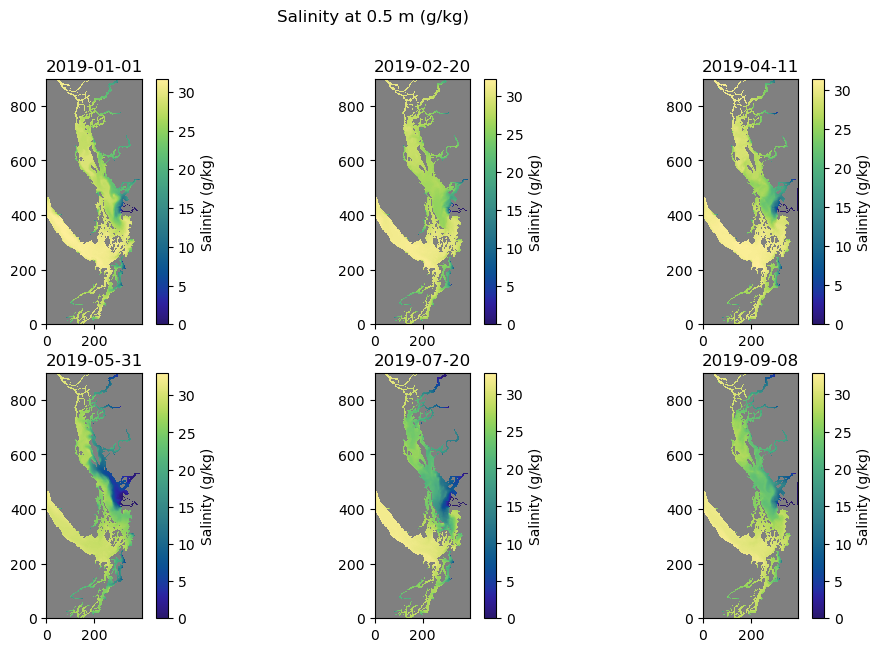

In [13]:
phys_arr_201905 = pre_process(physics_201905)

In [20]:
def do_pca(phys_arr):
    
    # define dimensions for later reshaping
    num_days = phys_arr.shape[0]

    Nx = phys_arr.shape[2]
    Ny = phys_arr.shape[3]

    ## DO PCA PART
    surface = phys_arr[:,0,:,:].reshape(num_days, 357404)  # TODO: FIX THIS to not hard coded
    surface = np.nan_to_num(surface)

    # does the PCA part
    n_modes = np.min(np.shape(surface))
    pca = PCA(n_components = n_modes)
    PCs = pca.fit_transform(surface)
    eigvecs = pca.components_
    fracVar = pca.explained_variance_ratio_

    #plot fraction of variance explained by each mode
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.scatter(range(len(fracVar)),fracVar, edgecolor = 'k')
    plt.xlabel('Mode Number', fontsize = 20)
    plt.ylabel('Fraction Variance', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.title('Variance Explained by All Modes', fontsize = 24)

    plt.subplot(1,2,2)
    n_modes_show = 10  # TODO change this to fun input
    plt.scatter(range(n_modes_show),fracVar[:n_modes_show], s = 100, edgecolor = 'k')
    plt.xlabel('Mode Number', fontsize = 20)
    plt.ylabel('Fraction Variance', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes', fontsize = 24)

    plt.tight_layout()

    # if saveIt:
    #     plt.savefig('tutorial4_fig3.png')

    plt.show()

    return(pca, surface, Nx, Ny)

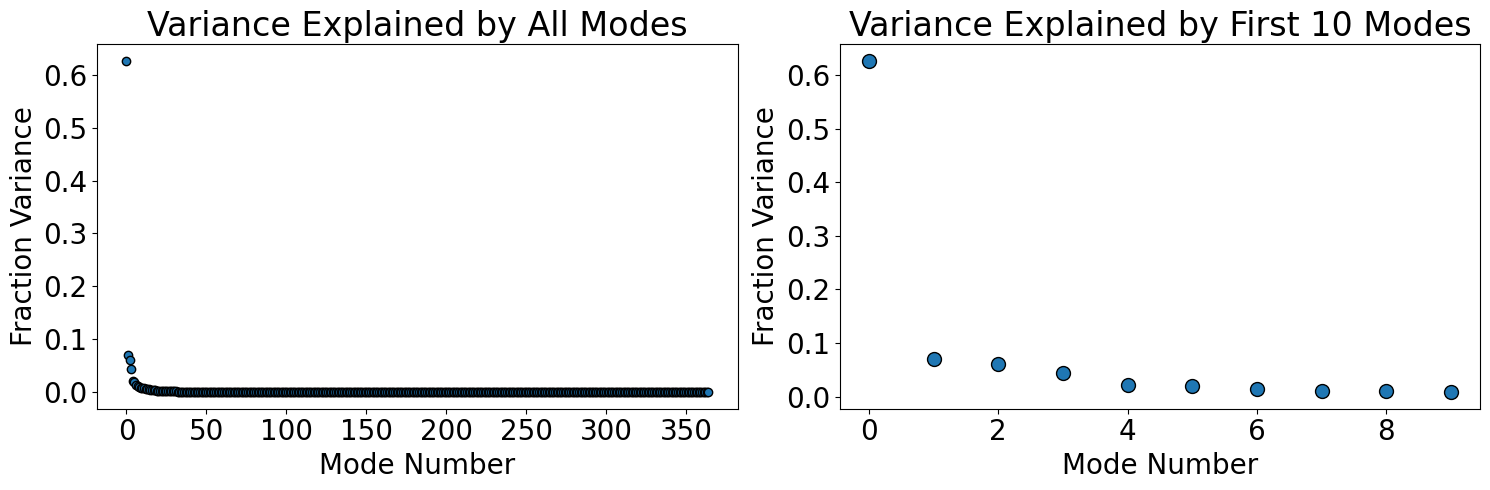

In [21]:
pca_params = do_pca(phys_arr_201905)

In [33]:
def show_pca(pca,surface,Nx,Ny,n):

    ## access the PCA results
    fracVar = pca.explained_variance_ratio_
    eigvecs = pca.components_
    PCs = pca.fit_transform(surface)

    np.sum(fracVar[:n]) # fraction of variance explained by this many modes  #TODO change this also to fn input, is the same n as below

    # make a mask of land where land is true and water in NaN
    bathymetry = xr.open_dataset('../../../../MEOPAR/grid/bathymetry_201702.nc')
    land = np.array(np.isnan(bathymetry.Bathymetry).to_numpy(), dtype='float')
    land[land == 0] = np.nan

    # open the mesh mask and use it to mask the land
    mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask201702.nc')
    # the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
    tmask = 1 - mesh.tmask[0]

    #plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure

    fig2, ax2 = plt.subplots(n, 2, figsize=(25, 5*n))

    for kk in range(n):
        
        plt.subplot(n,2,kk*2+1)
        to_show = np.ma.masked_array(np.flipud(np.reshape(eigvecs[kk],(Nx,Ny))), mask=tmask[0])
        cb = ax2[kk,0].imshow(np.flipud(np.reshape(eigvecs[kk],(Nx,Ny))), cmap='RdBu_r')
        plt.colorbar(cb)
        cb2 = ax2[kk,0].pcolormesh(np.flipud(land), cmap='BrBG')  ################## want
        viz_tools.set_aspect(ax2[kk,0]);
        
        
        ax2[kk,1].plot(PCs[:,kk], linewidth = 0.5)
        ax2[kk,1].set_title('PCs of Mode #' + str(kk+1) + "\n % Variance Explained: " + str(round(100*fracVar[kk],2)), fontsize = 24)
        ax2[kk,1].set_xlabel('Day', fontsize = 20)
        
    plt.tight_layout()

    # plt.savefig('2020_modes.png')
    plt.show()

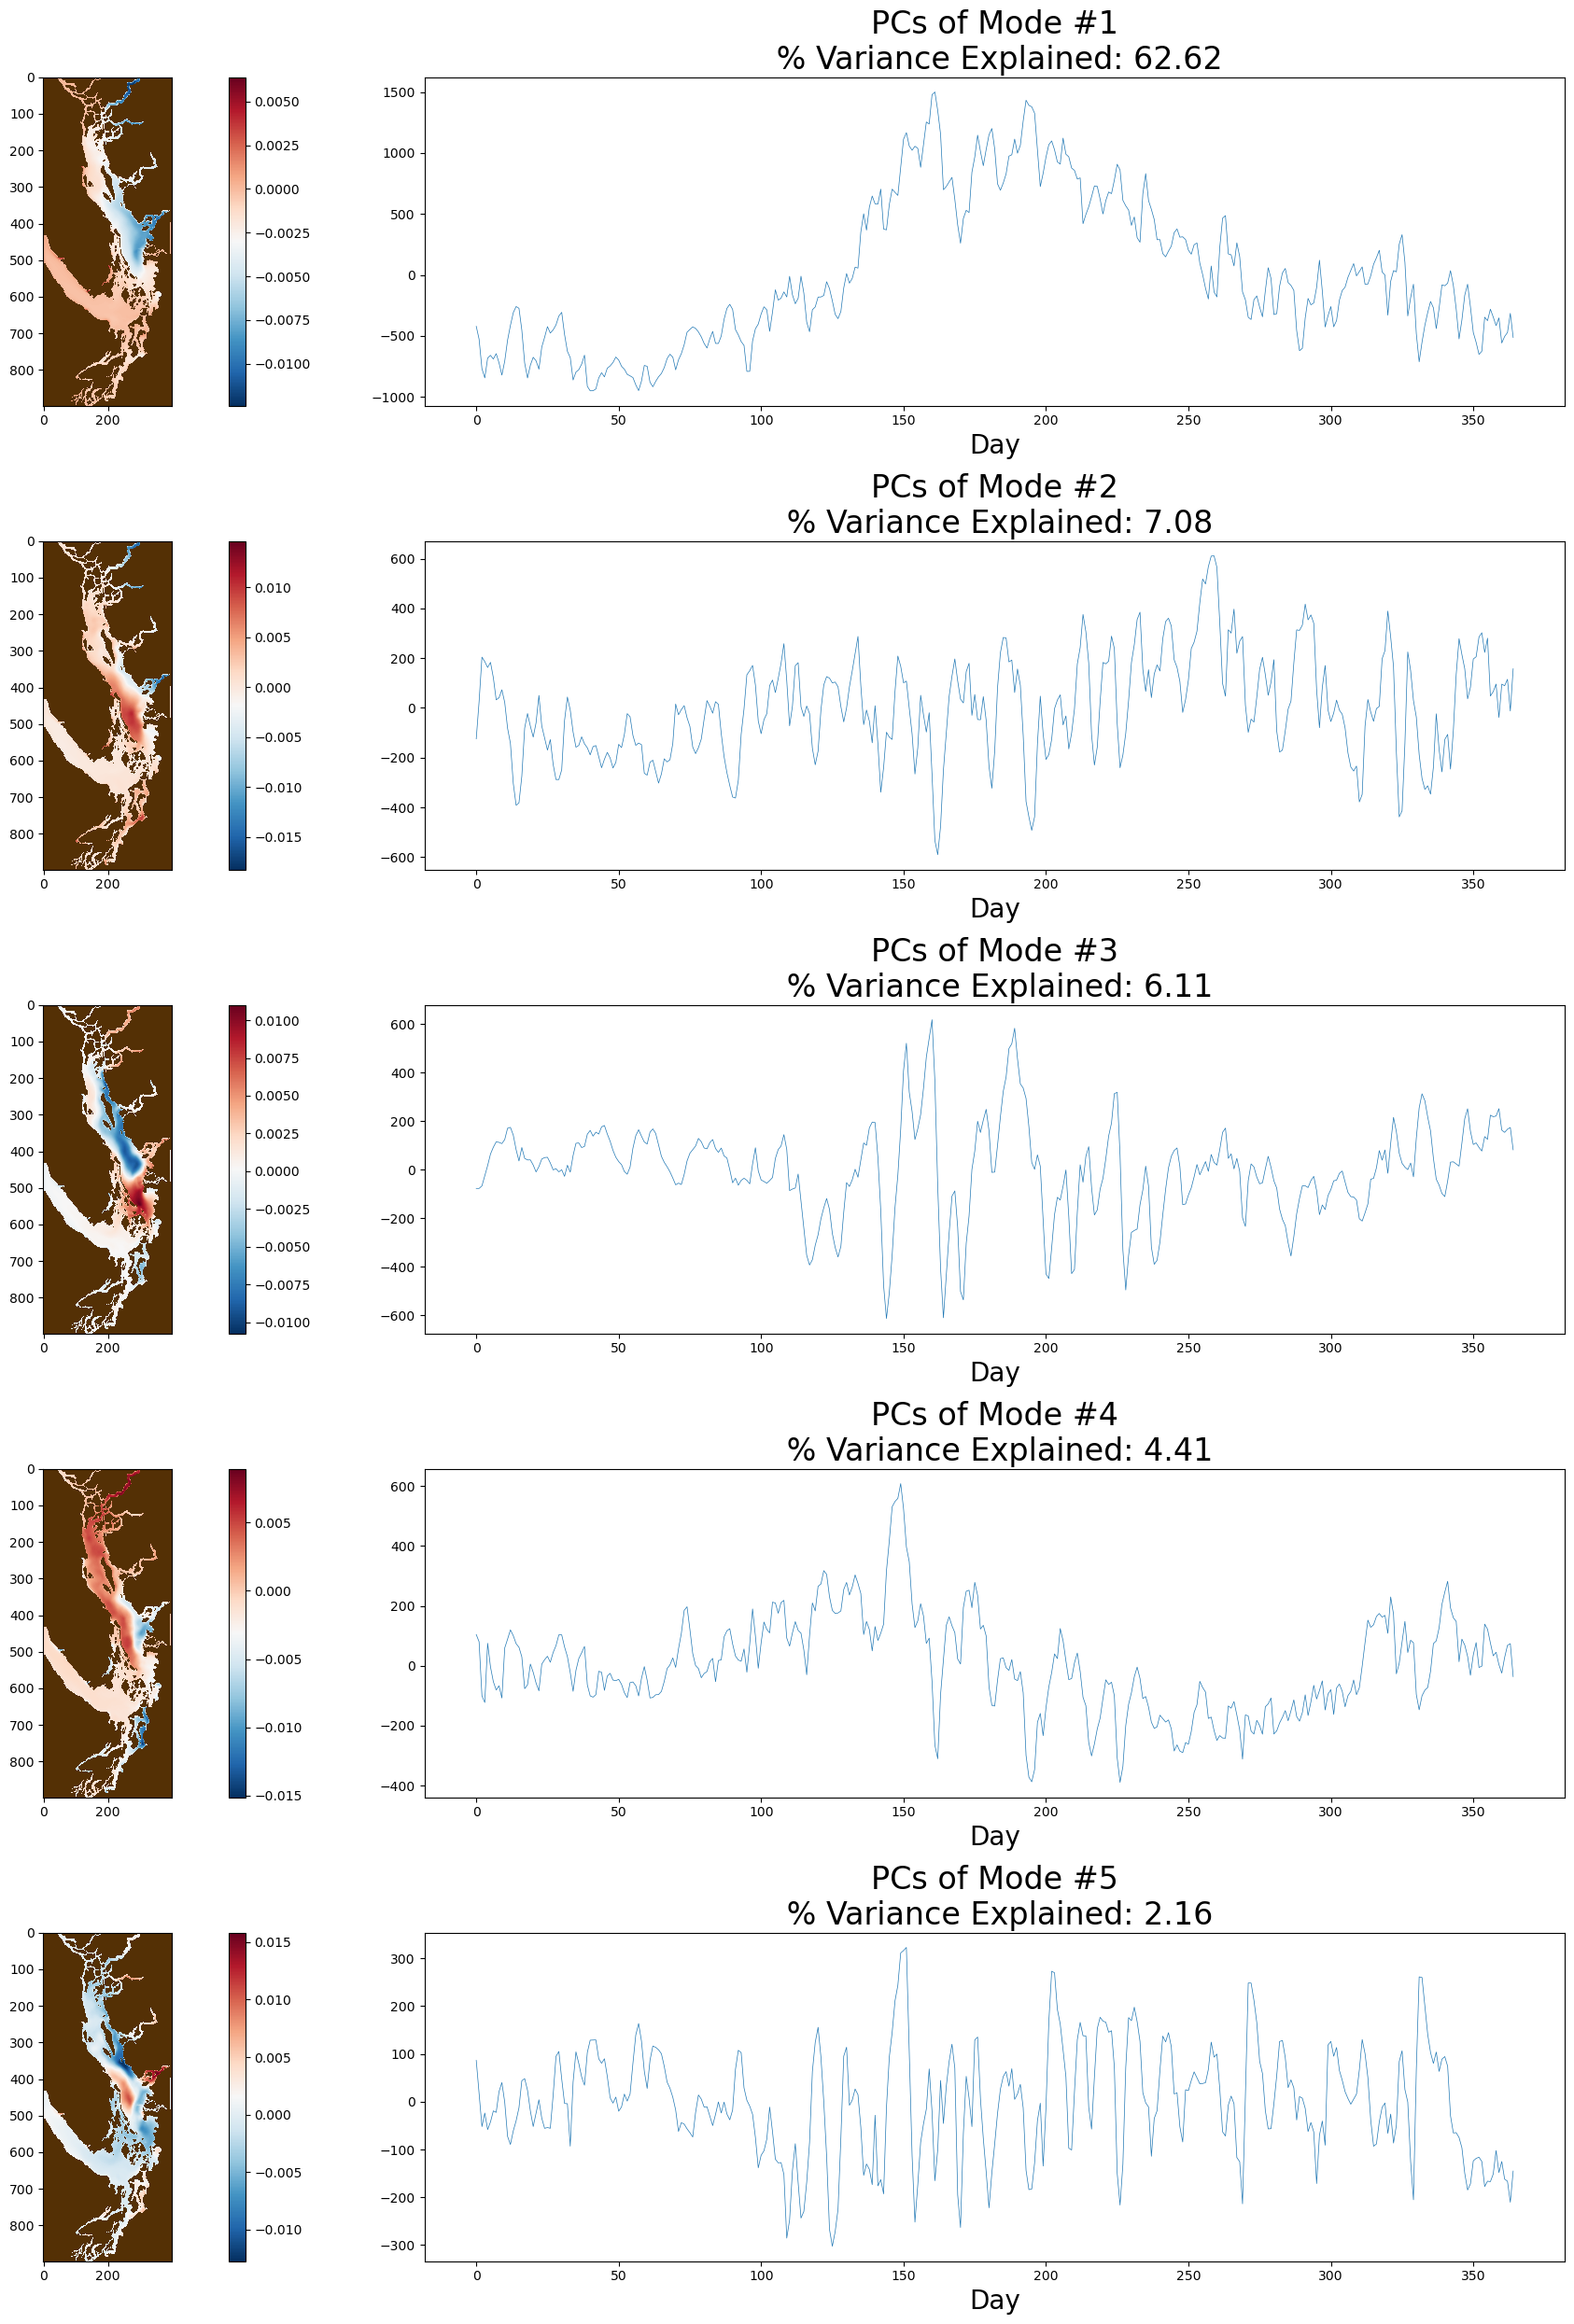

In [34]:
show_pca(*pca_params,5)

In [14]:
# phys_arr_201905 = physics_201905.vosaline.to_numpy()  # go from an xarray to a numpy array
# phys_arr_202111 = physics_202111.vosaline.to_numpy()

In [16]:
# num_days = phys_arr_202111.shape[0]

# # define dimensions for later reshaping
# Nx = phys_arr_202111.shape[2]
# Ny = phys_arr_202111.shape[3]

In [17]:
# # make a mask of land where land is true and water in NaN
# bathymetry = xr.open_dataset('../../../../MEOPAR/grid/bathymetry_201702.nc')
# land = np.array(np.isnan(bathymetry.Bathymetry).to_numpy(), dtype='float')
# land[land == 0] = np.nan

In [18]:
# # make the indicies for plotting six sample salinity fields
# plot_ind = np.array([[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]])
# plot_day = np.array([0, 50, 100, 150, 200, 250])  # this selects what days of each year to plot, change for > 1 year

In [19]:
# # open the mesh mask and use it to mask the land
# mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask201702.nc')
# # the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
# tmask = 1 - mesh.tmask[0]

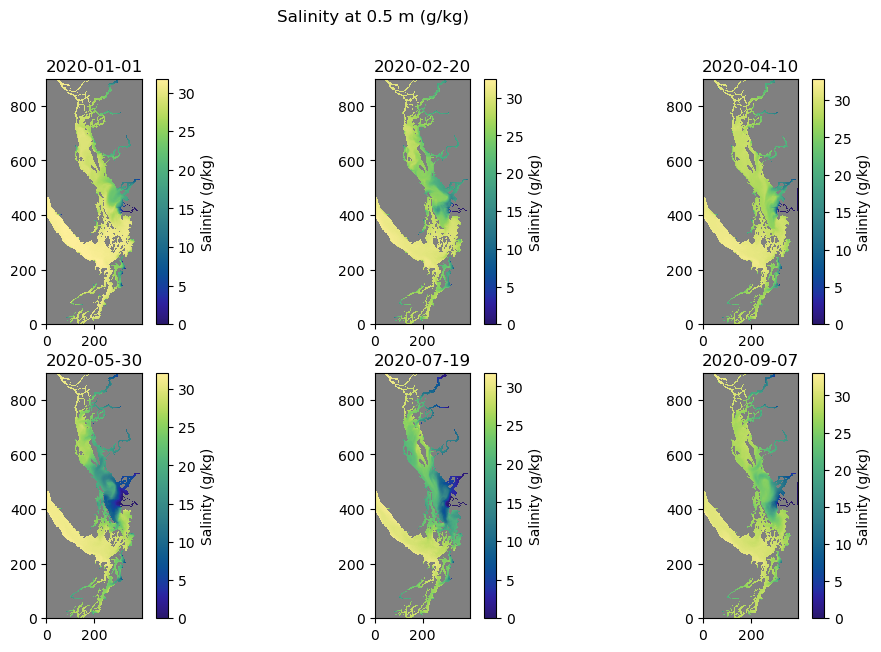

In [20]:
# kd = 0 ## this will stay for surface
# imin = 0
# imax = 898
# jmin = 0
# jmax = 398
# dm = physics

# fig1, ax1 = plt.subplots(2, 3, figsize=(12, 7))

# for i in np.arange(0,6):
    
#     cmap = cm.haline
#     cmap.set_bad('gray')

    
#     day = plot_day[i]
#     day_str = np.datetime_as_string(physics.time[day].values, unit='D')
#     # salinity plot
#     myarray = np.ma.array(dm.vosaline[day, kd, imin:imax, jmin:jmax])
#     salinity = np.ma.masked_array(myarray, mask=tmask[0])
#     colours = ax1[plot_ind[i][0], plot_ind[i][1]].pcolormesh(np.arange(jmin, jmax), np.arange(imin, imax), salinity, cmap=cm.haline, shading='auto')
#     ax1[plot_ind[i][0], plot_ind[i][1]].set_title(day_str)
#     cb = fig1.colorbar(colours, ax=ax1[plot_ind[i][0], plot_ind[i][1]])
#     cb.set_label('Salinity (g/kg)')
#     viz_tools.set_aspect(ax1[plot_ind[i][0], plot_ind[i][1]]);
    
    
# fig1.suptitle(f'Salinity at {kd+0.5} m (g/kg)')
# # plt.savefig('2020_samplesal.png')

#### 2. Do PCA!

In [21]:
# surface = phys_arr_202111[:,0,:,:].reshape(num_days, 357404)
# surface = np.nan_to_num(surface)

In [22]:
# n_modes = np.min(np.shape(surface))
# pca = PCA(n_components = n_modes)
# PCs = pca.fit_transform(surface)
# eigvecs = pca.components_
# fracVar = pca.explained_variance_ratio_

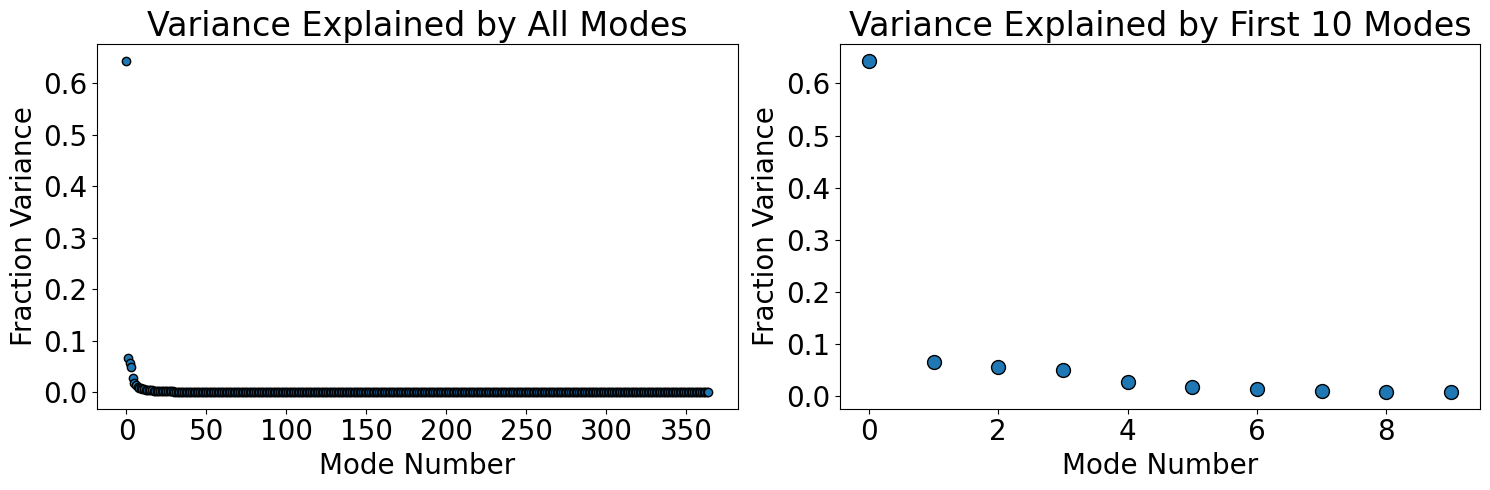

In [23]:
# #plot fraction of variance explained by each mode

# plt.figure(figsize=(15,5))

# plt.subplot(1,2,1)
# plt.scatter(range(len(fracVar)),fracVar, edgecolor = 'k')
# plt.xlabel('Mode Number', fontsize = 20)
# plt.ylabel('Fraction Variance', fontsize = 20)
# plt.xticks(fontsize = 20)
# plt.yticks(fontsize = 20)
# plt.title('Variance Explained by All Modes', fontsize = 24)

# plt.subplot(1,2,2)
# n_modes_show = 10
# plt.scatter(range(n_modes_show),fracVar[:n_modes_show], s = 100, edgecolor = 'k')
# plt.xlabel('Mode Number', fontsize = 20)
# plt.ylabel('Fraction Variance', fontsize = 20)
# plt.xticks(fontsize = 20)
# plt.yticks(fontsize = 20)
# plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes', fontsize = 24)

# plt.tight_layout()

# # if saveIt:
# #     plt.savefig('tutorial4_fig3.png')

# plt.show()

In [24]:
# np.sum(fracVar[:5]) # fraction of variance explained by this many modes

0.84196854

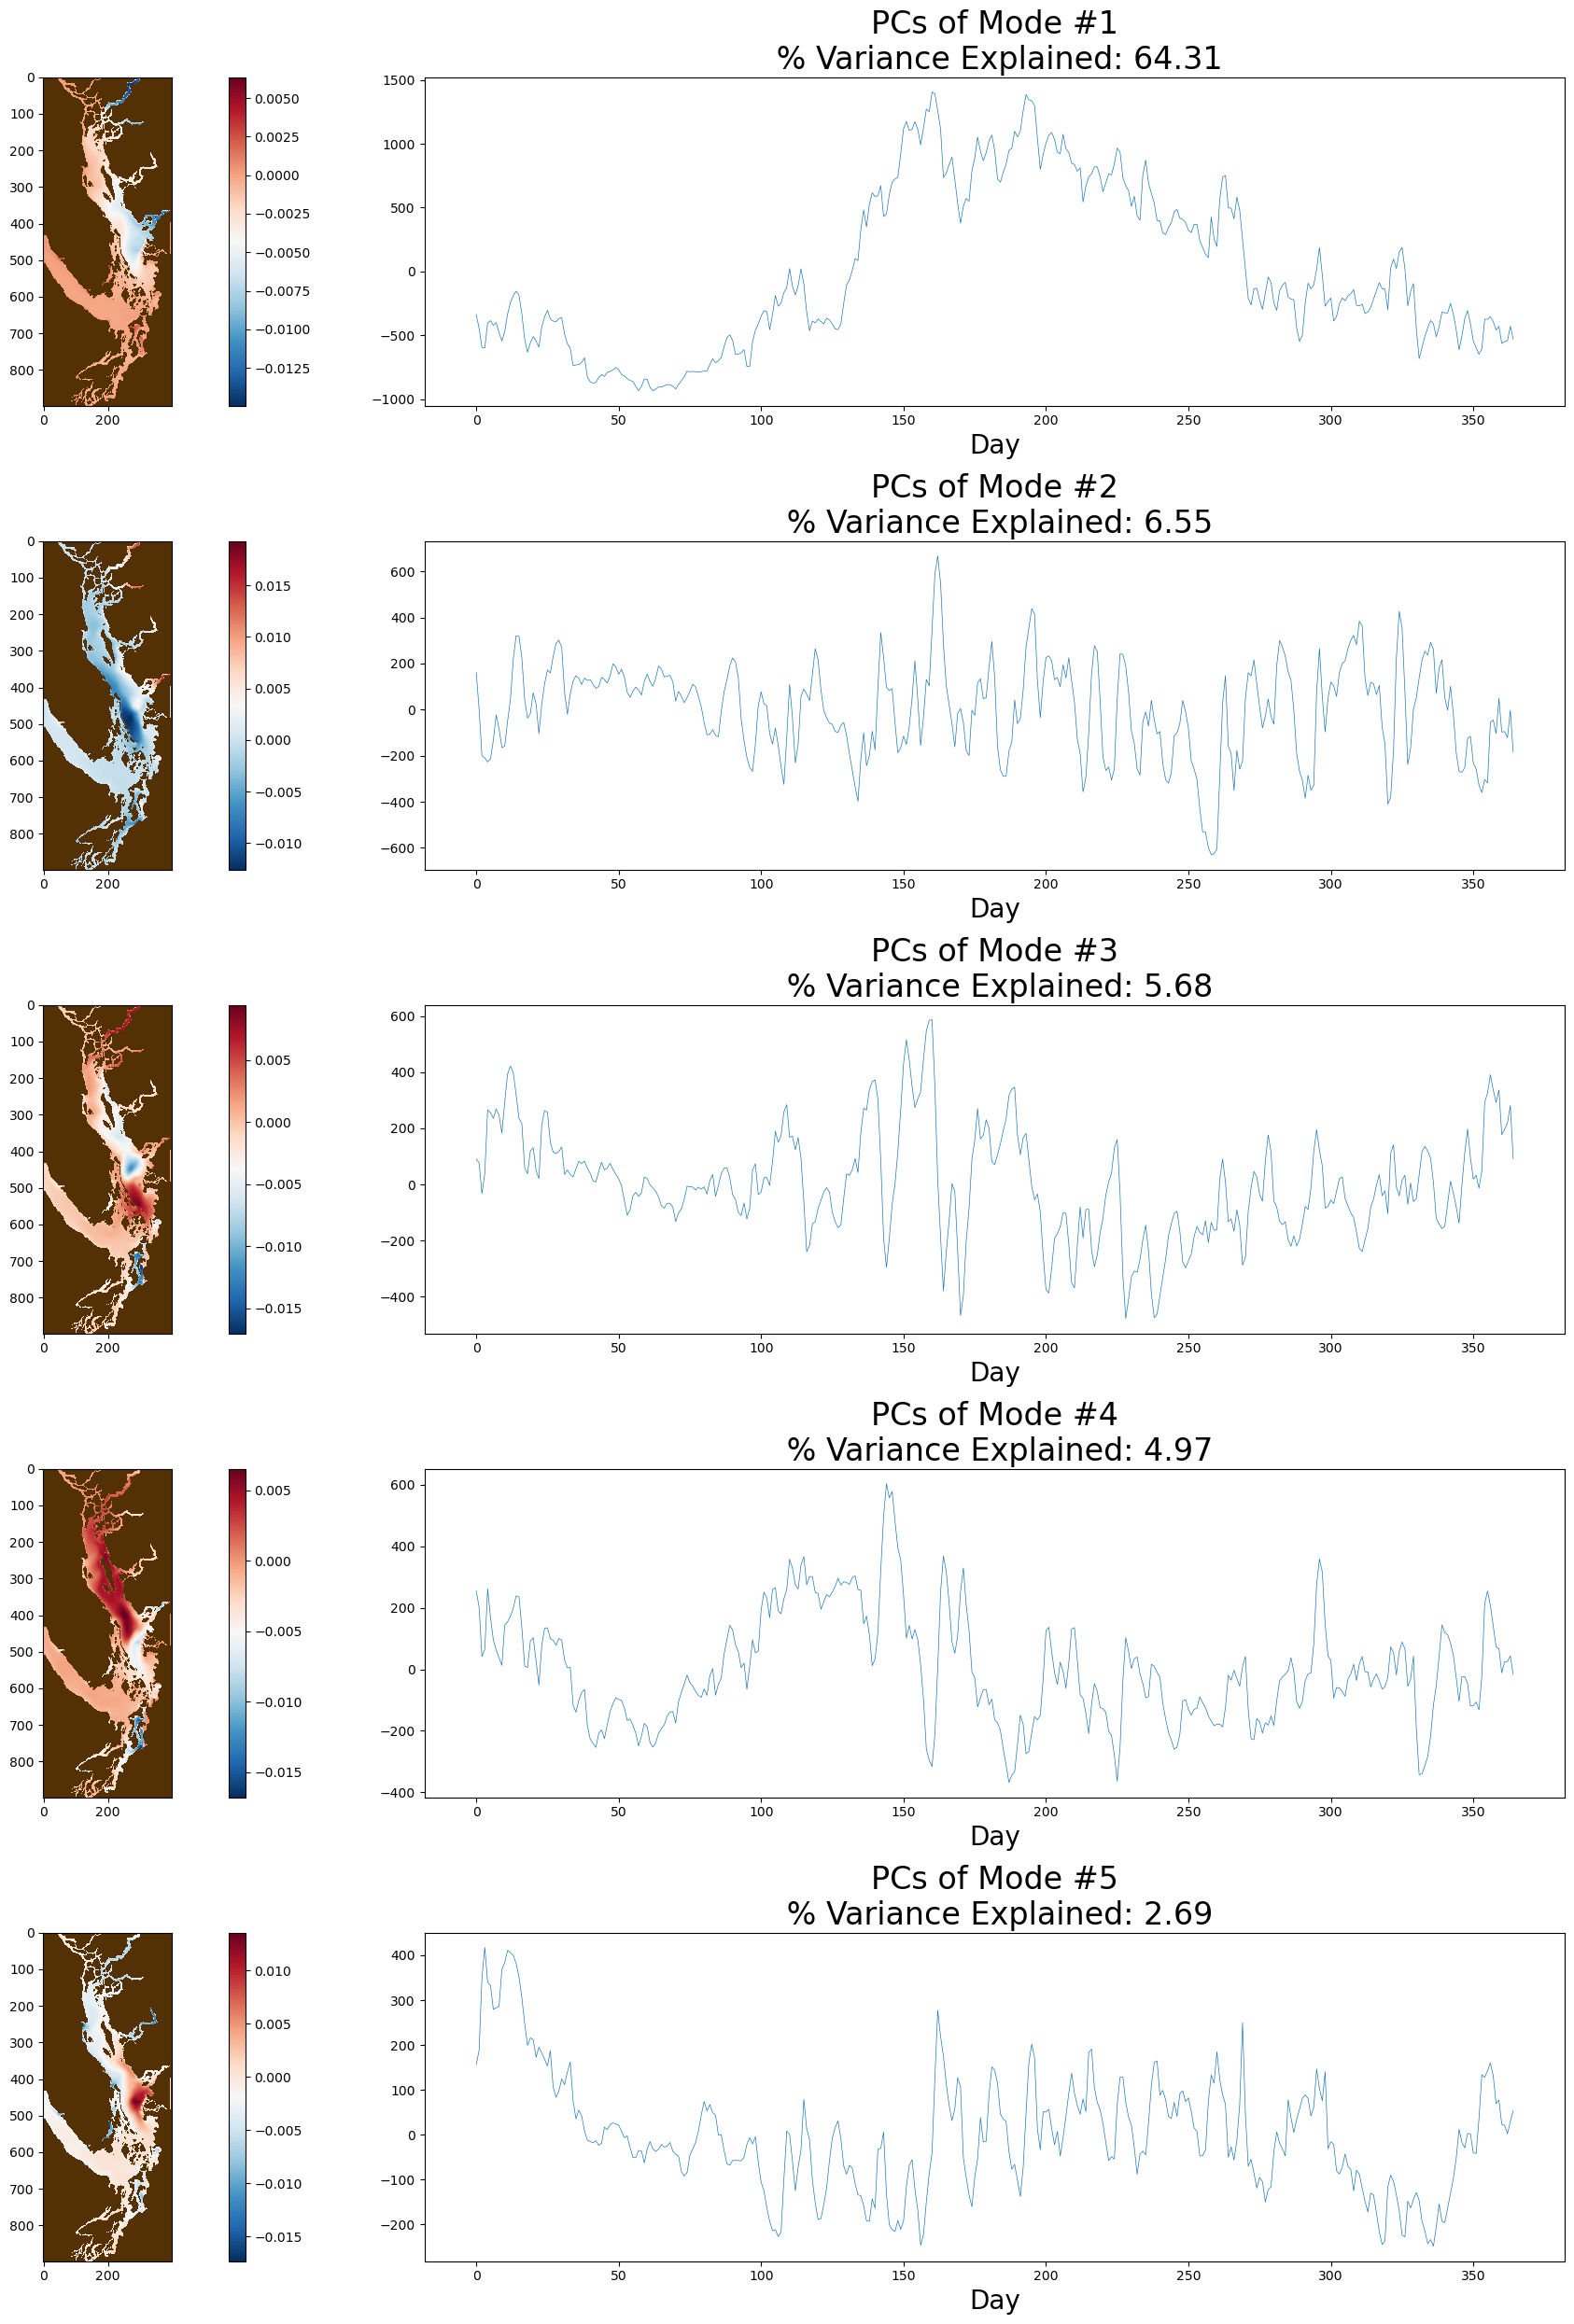

In [25]:
# #plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure!

# n = 5

# fig2, ax2 = plt.subplots(n, 2, figsize=(25, 5*n))

# for kk in range(n):
    
#     plt.subplot(n,2,kk*2+1)
#     to_show = np.ma.masked_array(np.flipud(np.reshape(eigvecs[kk],(Nx,Ny))), mask=tmask[0])
#     cb = ax2[kk,0].imshow(np.flipud(np.reshape(eigvecs[kk],(Nx,Ny))), cmap='RdBu_r')
#     plt.colorbar(cb)
#     cb2 = ax2[kk,0].pcolormesh(np.flipud(land), cmap='BrBG')  ################## want
#     viz_tools.set_aspect(ax2[kk,0]);
    
    
#     ax2[kk,1].plot(PCs[:,kk], linewidth = 0.5)
#     ax2[kk,1].set_title('PCs of Mode #' + str(kk+1) + "\n % Variance Explained: " + str(round(100*fracVar[kk],2)), fontsize = 24)
#     ax2[kk,1].set_xlabel('Day', fontsize = 20)
    
# plt.tight_layout()

# plt.savefig('2020_modes.png')
# plt.show()